# Introduction

# Problem Statement

# Objectives

# Data Understanding 
### Limitations

# Imports and Data Loading

#### Imports

In [226]:


import warnings

# Figures
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import statistics

# Data
import pandas as pd
import numpy as np
from operator import itemgetter
import itertools
from collections import defaultdict
from datetime import datetime

# Models, metrics, scalers and functionalities
from sklearn.linear_model import LinearRegression
from sklearn import svm

from sklearn.model_selection import cross_val_score, cross_val_predict, cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn.metrics import confusion_matrix, accuracy_score

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import LabelEncoder

from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif
from sklearn.feature_selection import RFE, RFECV
from sklearn.feature_selection import SelectFromModel

from sklearn.neighbors import KNeighborsClassifier

from sklearn.decomposition import PCA

from sklearn.tree import DecisionTreeClassifier
 
from IPython.display import Image
from sklearn.tree import export_graphviz

from sklearn.ensemble import RandomForestClassifier
from scipy.stats import randint

import xgboost
import pandas as pd
import numpy as np


#### Data Loading

In [227]:
training_set_values = pd.read_csv("data/training-set-values.csv")
training_set_labels = pd.read_csv("data/training-set-labels.csv")
print(training_set_values.shape)
print(training_set_labels.shape)

(59400, 40)
(59400, 2)


Both the training labels and values csvs have 59,400 rows. We will now combine them to deal with one training dataset

In [228]:
training_data = training_set_values.merge(training_set_labels, on='id')
training_data.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,...,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,...,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,functional
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,...,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,...,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional


#### EDA and Feature Exploration

In [229]:
training_data.shape

(59400, 41)

We now have one dataframe with 59,400 rows and 41 columns, with the 41st column being the status_group column

In [230]:
training_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59400 entries, 0 to 59399
Data columns (total 41 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     59400 non-null  int64  
 1   amount_tsh             59400 non-null  float64
 2   date_recorded          59400 non-null  object 
 3   funder                 55765 non-null  object 
 4   gps_height             59400 non-null  int64  
 5   installer              55745 non-null  object 
 6   longitude              59400 non-null  float64
 7   latitude               59400 non-null  float64
 8   wpt_name               59400 non-null  object 
 9   num_private            59400 non-null  int64  
 10  basin                  59400 non-null  object 
 11  subvillage             59029 non-null  object 
 12  region                 59400 non-null  object 
 13  region_code            59400 non-null  int64  
 14  district_code          59400 non-null  int64  
 15  lg

In [231]:
training_data.columns

Index(['id', 'amount_tsh', 'date_recorded', 'funder', 'gps_height',
       'installer', 'longitude', 'latitude', 'wpt_name', 'num_private',
       'basin', 'subvillage', 'region', 'region_code', 'district_code', 'lga',
       'ward', 'population', 'public_meeting', 'recorded_by',
       'scheme_management', 'scheme_name', 'permit', 'construction_year',
       'extraction_type', 'extraction_type_group', 'extraction_type_class',
       'management', 'management_group', 'payment', 'payment_type',
       'water_quality', 'quality_group', 'quantity', 'quantity_group',
       'source', 'source_type', 'source_class', 'waterpoint_type',
       'waterpoint_type_group', 'status_group'],
      dtype='object')

These are all the columns and their descriptions:
- **amount_tsh** - Total static head (amount water available to waterpoint)
- **date_recorded** - The date the row was entered
- **funder** - Who funded the well
- **gps_height** - Altitude of the well
- **installer** - Organization that installed the well
- **longitude** - GPS coordinate
- **latitude** - GPS coordinate
- **wpt_name** - Name of the waterpoint if there is one
- **num_private** -
- **basin** - Geographic water basin
- **subvillage** - Geographic location
- **region** - Geographic location
- **region_code** - Geographic location (coded)
- **district_code** - Geographic location (coded)
- **lga** - Geographic location
- **ward** - Geographic location
- **population** - Population around the well
- **public_meeting** - True/False
- **recorded_by** - Group entering this row of data
- **scheme_management** - Who operates the waterpoint
- **scheme_name** - Who operates the waterpoint
- **permit** - If the waterpoint is permitted
- **construction_year** - Year the waterpoint was constructed
- **extraction_type** - The kind of extraction the waterpoint uses
- **extraction_type_group** - The kind of extraction the waterpoint uses
- **extraction_type_class** - The kind of extraction the waterpoint uses
- **management** - How the waterpoint is managed
- **management_group** - How the waterpoint is managed
- **payment** - What the water costs
- **payment_type** - What the water costs
- **water_quality** - The quality of the water
- **quality_group** - The quality of the water
- **quantity** - The quantity of water
- **quantity_group** - The quantity of water
- **source** - The source of the water
- **source_type** - The source of the water
- **source_class** - The source of the water
- **waterpoint_type** - The kind of waterpoint
- **waterpoint_type_group** - The kind of waterpoint
- **status_group** - The labels in this dataset with three possible values: functional, non-functional, and functional needs repair

In [232]:
training_data.isna().sum() # to see the null values

id                           0
amount_tsh                   0
date_recorded                0
funder                    3635
gps_height                   0
installer                 3655
longitude                    0
latitude                     0
wpt_name                     0
num_private                  0
basin                        0
subvillage                 371
region                       0
region_code                  0
district_code                0
lga                          0
ward                         0
population                   0
public_meeting            3334
recorded_by                  0
scheme_management         3877
scheme_name              28166
permit                    3056
construction_year            0
extraction_type              0
extraction_type_group        0
extraction_type_class        0
management                   0
management_group             0
payment                      0
payment_type                 0
water_quality                0
quality_

The columns with missing values are:<br>
Funder : 3635  
Installer: 3635  
Subvillage: 371  
Public meeting: 3334  
scheme_management:3877  
scheme_name: 28166  
permit: 3056

There are some columns which contain null and the same information in the data set. 

Now, we will drop one for each because the same values or dublicated values do not affect our target, and when we simplify our data we can run our models easier. These are `management and scheme_management`, `payment and payment type`, `quantity and quantity group`, `waterpoint_type and waterpoint_type_group`, `extraction_type, extration_type_class, and extraction_type_group`, `source, source_type, and source_class`, `water_quality and quality_group`  Let's assess them to confirm.

#### Dealing with columns that have the same information

##### Management and Scheme_management

In [233]:
print(training_data.management.value_counts())
print("---------------------------------")
print(training_data.scheme_management.value_counts())

vwc                 40507
wug                  6515
water board          2933
wua                  2535
private operator     1971
parastatal           1768
water authority       904
other                 844
company               685
unknown               561
other - school         99
trust                  78
Name: management, dtype: int64
---------------------------------
VWC                 36793
WUG                  5206
Water authority      3153
WUA                  2883
Water Board          2748
Parastatal           1680
Private operator     1063
Company              1061
Other                 766
SWC                    97
Trust                  72
None                    1
Name: scheme_management, dtype: int64


These two columns has nearly same information. Scheme_management represents who operates the water point, 'management' represents how the water point is managed. There are 3877 null values in 'scheme_management' column so we prefer to keep the 'management' column. 

In [234]:
training_data = training_data.drop(columns = ['scheme_management'], axis=1)

##### Payment and Payment type

In [235]:
# Looking at payment and payment_type
print(training_data.payment.value_counts())
print("---------------------------------")
print(training_data.payment_type.value_counts())

never pay                25348
pay per bucket            8985
pay monthly               8300
unknown                   8157
pay when scheme fails     3914
pay annually              3642
other                     1054
Name: payment, dtype: int64
---------------------------------
never pay     25348
per bucket     8985
monthly        8300
unknown        8157
on failure     3914
annually       3642
other          1054
Name: payment_type, dtype: int64


These two columns have the same exact information, but `payment` has more details on the column naming, so we will keep it and drop`payment_type`

In [236]:
training_data = training_data.drop(columns = ['payment_type'], axis=1)

##### Quantity and Quantity_Group

In [237]:
# Looking at `quantity and quantity group`
print(training_data.quantity.value_counts())
print("---------------------------------")
print(training_data.quantity_group.value_counts())

enough          33186
insufficient    15129
dry              6246
seasonal         4050
unknown           789
Name: quantity, dtype: int64
---------------------------------
enough          33186
insufficient    15129
dry              6246
seasonal         4050
unknown           789
Name: quantity_group, dtype: int64


These have the same exact information, so we can drop either

In [238]:
training_data = training_data.drop(columns = ['quantity_group'], axis=1)

##### Waterpoint and Waterpoint_type_group

In [239]:
# Looking at the waterpoint_type and waterpoint_type_group columns
print(training_data.waterpoint_type.value_counts())
print("---------------------------------")
print(training_data.waterpoint_type_group.value_counts())

communal standpipe             28522
hand pump                      17488
other                           6380
communal standpipe multiple     6103
improved spring                  784
cattle trough                    116
dam                                7
Name: waterpoint_type, dtype: int64
---------------------------------
communal standpipe    34625
hand pump             17488
other                  6380
improved spring         784
cattle trough           116
dam                       7
Name: waterpoint_type_group, dtype: int64


`Waterpoint_type` has more information and distribution, so we will keep it and drop `waterpoint_type_group`

In [240]:
training_data = training_data.drop(columns = ['waterpoint_type_group'], axis=1)

##### Extraction_type, Extraction_type_class and Extraction_type_group columns

In [241]:
# Let's look at the extraction_type, extraction_type_class and extraction_type_group columns
print(training_data.extraction_type.value_counts())

gravity                      26780
nira/tanira                   8154
other                         6430
submersible                   4764
swn 80                        3670
mono                          2865
india mark ii                 2400
afridev                       1770
ksb                           1415
other - rope pump              451
other - swn 81                 229
windmill                       117
india mark iii                  98
cemo                            90
other - play pump               85
walimi                          48
climax                          32
other - mkulima/shinyanga        2
Name: extraction_type, dtype: int64


In [242]:
print(training_data.extraction_type_group.value_counts())

gravity            26780
nira/tanira         8154
other               6430
submersible         6179
swn 80              3670
mono                2865
india mark ii       2400
afridev             1770
rope pump            451
other handpump       364
other motorpump      122
wind-powered         117
india mark iii        98
Name: extraction_type_group, dtype: int64


In [224]:
print(training_data.extraction_type_class.value_counts())

gravity         26780
handpump        16456
other            6430
submersible      6179
motorpump        2987
rope pump         451
wind-powered      117
Name: extraction_type_class, dtype: int64


It is obviously seen that these three columns keep same information. So, we decided to keep `extraction_type_group` and drop others. Although, `extraction_type` has more unique values than `extraction_type_group` , some of these values are very small amount according to this big dataset. We prefered to use more compact one. Also, `extraction_type_class` contains less detail. 

In [243]:
training_data = training_data.drop(columns = ['extraction_type_class'], axis=1)

In [244]:
training_data = training_data.drop(columns = ['extraction_type'], axis=1)

##### Source, Source_type_and Source_class

In [245]:
# Let's assess the source, source_type_and source_class columns
# SOURCE
print(training_data.source.value_counts())

spring                  17021
shallow well            16824
machine dbh             11075
river                    9612
rainwater harvesting     2295
hand dtw                  874
lake                      765
dam                       656
other                     212
unknown                    66
Name: source, dtype: int64


In [246]:
# SOURCE TYPE
print(training_data.source_type.value_counts())

spring                  17021
shallow well            16824
borehole                11949
river/lake              10377
rainwater harvesting     2295
dam                       656
other                     278
Name: source_type, dtype: int64


In [247]:
# SOURCE CLASS
print(training_data.source_class.value_counts())

groundwater    45794
surface        13328
unknown          278
Name: source_class, dtype: int64


It is obvious that these columns have the same information. We will keep the `source` column and drop the rest since it has more information

In [248]:
training_data = training_data.drop(columns = 'source_type', axis=1)

In [196]:
training_data = training_data.drop(columns = 'source_class', axis=1)

##### Water_quality and Quality_group

In [249]:
# Looking at the water_quality and quality_group columns
print(training_data.water_quality.value_counts())
print("---------------------------------")
print(training_data.quality_group.value_counts())

soft                  50818
salty                  4856
unknown                1876
milky                   804
coloured                490
salty abandoned         339
fluoride                200
fluoride abandoned       17
Name: water_quality, dtype: int64
---------------------------------
good        50818
salty        5195
unknown      1876
milky         804
colored       490
fluoride      217
Name: quality_group, dtype: int64


Since `water_quality` has more information, we will keep it and drop `quality _group`

In [250]:
training_data = training_data.drop(columns = 'quality_group', axis=1)

In [251]:
# Let's look at our new data
training_data.columns

Index(['id', 'amount_tsh', 'date_recorded', 'funder', 'gps_height',
       'installer', 'longitude', 'latitude', 'wpt_name', 'num_private',
       'basin', 'subvillage', 'region', 'region_code', 'district_code', 'lga',
       'ward', 'population', 'public_meeting', 'recorded_by', 'scheme_name',
       'permit', 'construction_year', 'extraction_type_group', 'management',
       'management_group', 'payment', 'water_quality', 'quantity', 'source',
       'source_class', 'waterpoint_type', 'status_group'],
      dtype='object')

In [252]:
training_data.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,extraction_type_group,management,management_group,payment,water_quality,quantity,source,source_class,waterpoint_type,status_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,...,gravity,vwc,user-group,pay annually,soft,enough,spring,groundwater,communal standpipe,functional
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,gravity,wug,user-group,never pay,soft,insufficient,rainwater harvesting,surface,communal standpipe,functional
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,...,gravity,vwc,user-group,pay per bucket,soft,enough,dam,surface,communal standpipe multiple,functional
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,...,submersible,vwc,user-group,never pay,soft,dry,machine dbh,groundwater,communal standpipe multiple,non functional
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,...,gravity,other,other,never pay,soft,seasonal,rainwater harvesting,surface,communal standpipe,functional


#### Dealing with Null Values

In [ ]:
training_data.isna().sum()

Let's deal with the columns containing missing values, starting with Funder

##### Funder

In [197]:
training_data.funder.value_counts()

Government Of Tanzania      9084
Danida                      3114
Hesawa                      2202
Rwssp                       1374
World Bank                  1349
                            ... 
Issa Mohamedi Tumwanga         1
Kindoroko Water Project        1
Government /world Vision       1
Seleman Seif                   1
Kibara Foundation              1
Name: funder, Length: 1897, dtype: int64

In [254]:
training_data.funder.value_counts()

Government Of Tanzania      9084
Danida                      3114
Hesawa                      2202
Rwssp                       1374
World Bank                  1349
                            ... 
Issa Mohamedi Tumwanga         1
Kindoroko Water Project        1
Government /world Vision       1
Seleman Seif                   1
Kibara Foundation              1
Name: funder, Length: 1897, dtype: int64

The `funder` column has 1897 unique values, hence it will be difficult to fill the null ones. We will drop it

In [255]:
training_data = training_data.drop(columns = 'funder', axis=1)

##### Subvillage

In [256]:
training_data["subvillage"].value_counts()

Madukani       508
Shuleni        506
Majengo        502
Kati           373
Mtakuja        262
              ... 
Luilo            1
Ng'Hami          1
Rugukwa          1
Malinoni         1
Mapambazuko      1
Name: subvillage, Length: 19287, dtype: int64

In [259]:
len(training_data[training_data["subvillage"].isnull()]["subvillage"])/len(training_data)*100

0.6245791245791246

Given the great scatter (not one subvillage accounts for 1% or more of the examples) this feature is not informative, and therefore dropped.

In [260]:
training_data = training_data.drop(columns = 'subvillage', axis=1)

##### Public Meeting

In [261]:
training_data["public_meeting"].value_counts(dropna = False)/len(training_data)*100

True     85.877104
False     8.510101
NaN       5.612795
Name: public_meeting, dtype: float64

As it is hard to assume whether or not public meetings were actually held, we consider binning this variable into:

True  
False  
Unknown  

##### Scheme Name

In [262]:
training_data["scheme_name"].value_counts(dropna = False)/len(training_data)*100

NaN                        47.417508
K                           1.148148
None                        1.084175
Borehole                    0.919192
Chalinze wate               0.681818
                             ...    
Msengoni water supply       0.001684
Nyakahura Water  Supply     0.001684
Leoroma water supply        0.001684
Mashangwi                   0.001684
Uswa                        0.001684
Name: scheme_name, Length: 2697, dtype: float64

`scheme_name` has about half the entries as NaN, and the rest are greatly scattered. Feature `scheme_name` is consequently dropped as well.

##### Permit

In [263]:
training_data["permit"].value_counts(dropna = False)/len(training_data)*100

True     65.407407
False    29.447811
NaN       5.144781
Name: permit, dtype: float64

`permit` is an intuitive binary feature. About 5% of the values are missing (NaN). It is reasonable to assume that absence of a permit record implies the absence of the permit itself, and hence the NaN values could be imputed as False

In [264]:
training_data = training_data.replace({"permit": {np.nan: False}})

#### Checking for duplicates

In [198]:
training_data.describe() # to see numeric columns detailed

,id,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year
count,59400.000000,59400.000000,59400.000000,59400.000000,5.940000e+04,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000
mean,37115.131768,317.650385,668.297239,34.077427,-5.706033e+00,0.474141,15.297003,5.629747,179.909983,1300.652475
std,21453.128371,2997.574558,693.116350,6.567432,2.946019e+00,12.236230,17.587406,9.633649,471.482176,951.620547
min,0.000000,0.000000,-90.000000,0.000000,-1.164944e+01,0.000000,1.000000,0.000000,0.000000,0.000000
25%,18519.750000,0.000000,0.000000,33.090347,-8.540621e+00,0.000000,5.000000,2.000000,0.000000,0.000000
50%,37061.500000,0.000000,369.000000,34.908743,-5.021597e+00,0.000000,12.000000,3.000000,25.000000,1986.000000
75%,55656.500000,20.000000,1319.250000,37.178387,-3.326156e+00,0.000000,17.000000,5.000000,215.000000,2004.000000
max,74247.000000,350000.000000,2770.000000,40.345193,-2.000000e-08,1776.000000,99.000000,80.000000,30500.000000,2013.000000


In [199]:
numeric_columns = training_data[['amount_tsh', 'gps_height','longitude', 'latitude', 'num_private', 'region_code', 'district_code', 'population', 'construction_year']]
numeric_columns.isna().sum()

amount_tsh           0
gps_height           0
longitude            0
latitude             0
num_private          0
region_code          0
district_code        0
population           0
construction_year    0
dtype: int64

None of the numeric columns have missing data and all of them seem to be continuous and not categorical. 

In [200]:
training_data['status_group'].value_counts()

functional                 32259
non functional             22824
functional needs repair     4317
Name: status_group, dtype: int64

We have highly imbalanced target values.

In [201]:
# There are no missing values in the target data
training_data['status_group'].isnull().sum()

0

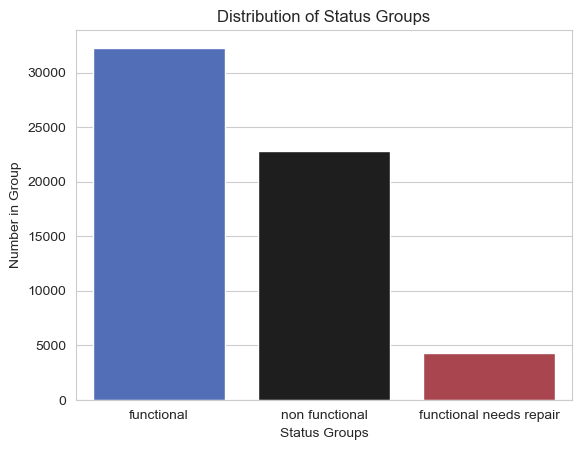

In [202]:
# Let's look at the distribution of the target
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style("whitegrid")

target_histplot = sns.countplot(x= training_data['status_group'], palette="icefire")


target_histplot.set_title("Distribution of Status Groups")
target_histplot.set_ylabel('Number in Group')
target_histplot.set_xlabel('Status Groups')
target_histplot;

In [203]:
sns.color_palette;